<div align="center">

#### Lab 3

# National Tsing Hua University

#### Spring 2025

#### 11320IEEM 513600

#### Deep Learning and Industrial Applications
    
## Lab 3: Anomaly Detection in Industrial Applications

</div>

### Introduction

In today's industrial landscape, the ability to detect anomalies in manufacturing processes and products is critical for maintaining quality, efficiency, and safety. This lab focuses on leveraging deep learning techniques for anomaly detection in various industrial applications, using the MVTEC Anomaly Detection Dataset. By employing ImageNet-pretrained models available in torchvision, students will gain hands-on experience in classfying defects and irregularities across different types of industrial products.

Throughout this lab, you'll be involved in the following key activities:
- Explore and process the MVTec Anomaly Detection Dataset.
- Apply ImageNet-pretrained models from [Torchvision](https://pytorch.org/vision/stable/models.html) to detect anomalies in industrial products.
- Evaluate the performance of the models to understand their effectiveness in real-world industrial applications.

### Objectives

- Understand the principles of anomaly detection in the context of industrial applications.
- Learn how to implement and utilize ImageNet-pretrained models for detecting anomalies.
- Analyze and interpret the results of the anomaly detection models to assess their practicality in industrial settings.

### Dataset

The MVTec AD Dataset is a comprehensive collection of high-resolution images across different categories of industrial products, such as bottles, cables, and metal nuts, each with various types of defects. This dataset is pivotal for developing and benchmarking anomaly detection algorithms. You can download our lab's dataset [here](https://drive.google.com/file/d/19600hUOpx0hl78TdpdH0oyy-gGTk_F_o/view?usp=share_link). You can drop downloaded data and drop to colab, or you can put into yor google drive.

### References
- [MVTec AD Dataset](https://www.kaggle.com/datasets/ipythonx/mvtec-ad/data) for the dataset used in this lab.
- [Torchvision Models](https://pytorch.org/vision/stable/models.html) for accessing ImageNet-pretrained models to be used in anomaly detection tasks.
- [State-of-the-Art Anomaly Detection on MVTec AD](https://paperswithcode.com/sota/anomaly-detection-on-mvtec-ad) for insights into the latest benchmarks and methodologies in anomaly detection applied to the MVTec AD dataset.
- [CVPR 2019: MVTec AD — A Comprehensive Real-World Dataset for Unsupervised Anomaly Detection] for the original paper of MVTec AD dataset.

In [190]:
import glob
import matplotlib.pyplot as plt
import random
from tqdm.auto import tqdm
import cv2
import numpy as np
import os
import torch
from torchvision.datasets import DatasetFolder, ImageFolder
from collections import defaultdict

In [191]:
# SEED
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True  
    torch.backends.cudnn.benchmark = False     

set_seed(1314520)

In [192]:
file_paths = glob.glob('archive/transistor/**/*.png', recursive=True)
file_paths = sorted([path for path in file_paths if os.path.basename(path) in [f'{i:03}.png' for i in range(10)]])


In [193]:
file_paths

['archive/transistor\\test\\bent_lead\\000.png',
 'archive/transistor\\test\\bent_lead\\001.png',
 'archive/transistor\\test\\bent_lead\\002.png',
 'archive/transistor\\test\\bent_lead\\003.png',
 'archive/transistor\\test\\bent_lead\\004.png',
 'archive/transistor\\test\\bent_lead\\005.png',
 'archive/transistor\\test\\bent_lead\\006.png',
 'archive/transistor\\test\\bent_lead\\007.png',
 'archive/transistor\\test\\bent_lead\\008.png',
 'archive/transistor\\test\\bent_lead\\009.png',
 'archive/transistor\\test\\cut_lead\\000.png',
 'archive/transistor\\test\\cut_lead\\001.png',
 'archive/transistor\\test\\cut_lead\\002.png',
 'archive/transistor\\test\\cut_lead\\003.png',
 'archive/transistor\\test\\cut_lead\\004.png',
 'archive/transistor\\test\\cut_lead\\005.png',
 'archive/transistor\\test\\cut_lead\\006.png',
 'archive/transistor\\test\\cut_lead\\007.png',
 'archive/transistor\\test\\cut_lead\\008.png',
 'archive/transistor\\test\\cut_lead\\009.png',
 'archive/transistor\\test\\da

In [194]:
all_data = []

for img in tqdm(file_paths):
    img = cv2.imread(img)
    img = img[..., ::-1]
    all_data.append(img)

all_data = np.stack(all_data)
print(all_data.shape)

100%|██████████| 60/60 [00:00<00:00, 60.39it/s]


(60, 1024, 1024, 3)


Classes: ['bent_lead', 'cut_lead', 'damaged_case', 'good', 'misplaced']


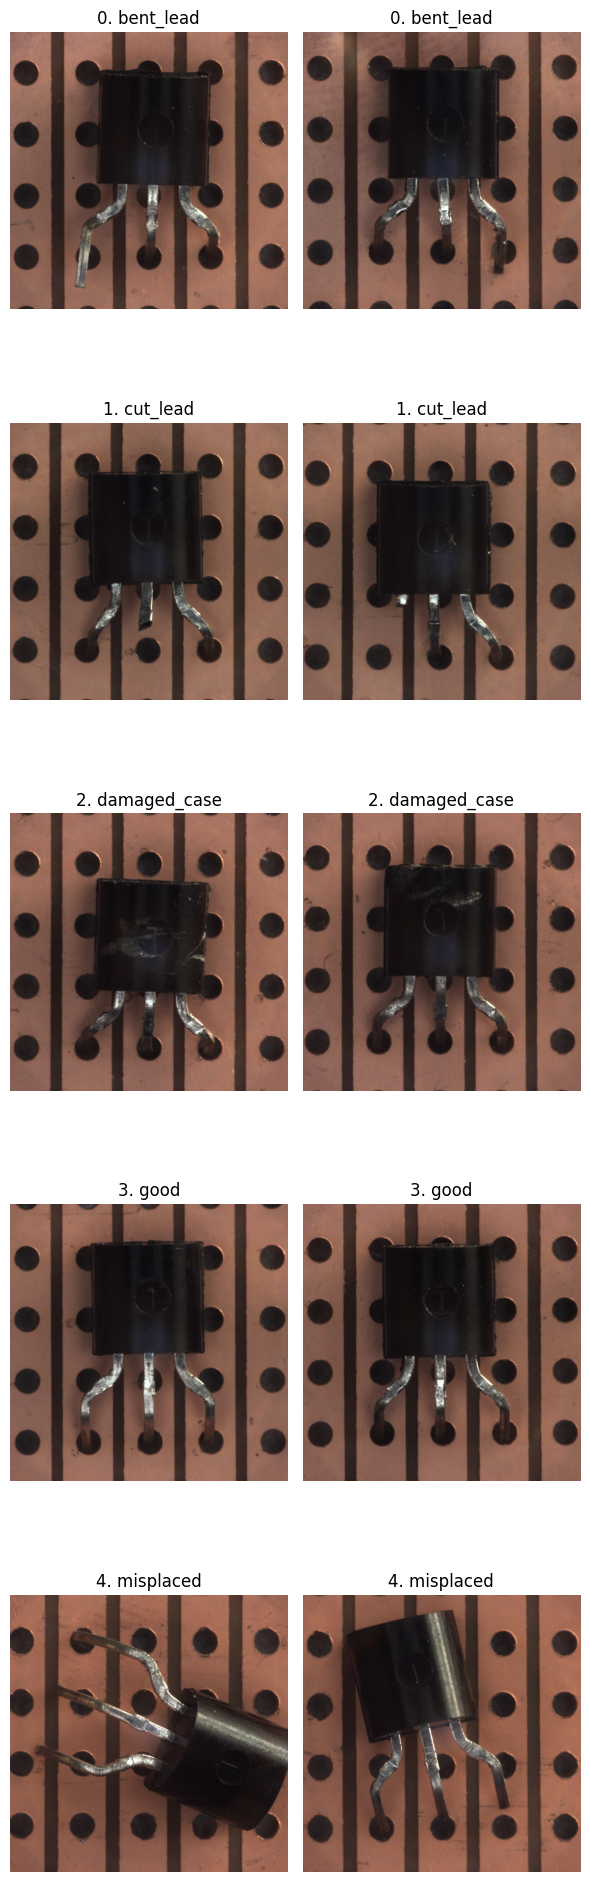

In [195]:
import matplotlib.pyplot as plt
import numpy as np

classes = sorted(set([path.split('\\')[2] for path in file_paths]))

print(f'Classes: {classes}')

images_per_class = len(all_data) // len(classes)
fig, axs = plt.subplots(len(classes), 2, figsize=(6, 4 * len(classes)))

for i, class_name in enumerate(classes):
    index = i * images_per_class
    for j in range(2):
        axs[i, j].set_title(f'{i}. {class_name}')
        axs[i, j].imshow(all_data[index + j])
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()

## A. Data Loading and Preprocessing

In [196]:
class_names = ['good', 'bent_lead', 'cut_lead', 'damaged_case', 'misplaced']
label_map = {name: i for i, name in enumerate(class_names)}

In [197]:
file_paths

['archive/transistor\\test\\bent_lead\\000.png',
 'archive/transistor\\test\\bent_lead\\001.png',
 'archive/transistor\\test\\bent_lead\\002.png',
 'archive/transistor\\test\\bent_lead\\003.png',
 'archive/transistor\\test\\bent_lead\\004.png',
 'archive/transistor\\test\\bent_lead\\005.png',
 'archive/transistor\\test\\bent_lead\\006.png',
 'archive/transistor\\test\\bent_lead\\007.png',
 'archive/transistor\\test\\bent_lead\\008.png',
 'archive/transistor\\test\\bent_lead\\009.png',
 'archive/transistor\\test\\cut_lead\\000.png',
 'archive/transistor\\test\\cut_lead\\001.png',
 'archive/transistor\\test\\cut_lead\\002.png',
 'archive/transistor\\test\\cut_lead\\003.png',
 'archive/transistor\\test\\cut_lead\\004.png',
 'archive/transistor\\test\\cut_lead\\005.png',
 'archive/transistor\\test\\cut_lead\\006.png',
 'archive/transistor\\test\\cut_lead\\007.png',
 'archive/transistor\\test\\cut_lead\\008.png',
 'archive/transistor\\test\\cut_lead\\009.png',
 'archive/transistor\\test\\da

In [198]:
class_data = defaultdict(list)
target_size = (256, 256)

for path in tqdm(file_paths):
    img = cv2.imread(path)
    if img is None:
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)

    if 'train' in path:
        class_name = 'good'
    else:
        class_name = path.split('\\')[2]

    if class_name in class_names:
        class_data[class_name].append(img)

100%|██████████| 60/60 [00:01<00:00, 56.25it/s]


In [199]:
x_train, y_train, x_val, y_val = [], [], [], []
train_ratio = 0.8

for class_name in class_names:
    imgs = class_data[class_name]
    n = len(imgs)
    split = int(n * train_ratio)

    x_train.extend(imgs[:split])
    y_train.extend([label_map[class_name]] * split)

    x_val.extend(imgs[split:])
    y_val.extend([label_map[class_name]] * (n - split))

    print(f"{class_name}：共 {n} 張圖，訓練 {split}，驗證 {n - split}")

x_train = np.transpose(np.array(x_train), (0, 3, 1, 2))
x_val = np.transpose(np.array(x_val), (0, 3, 1, 2))
y_train = np.array(y_train)
y_val = np.array(y_val)

print(f"\nx_train: {x_train.shape}, y_train: {y_train.shape}")
print(f"x_val:   {x_val.shape}, y_val:   {y_val.shape}")
print(f"{label_map}")

good：共 20 張圖，訓練 16，驗證 4
bent_lead：共 10 張圖，訓練 8，驗證 2
cut_lead：共 10 張圖，訓練 8，驗證 2
damaged_case：共 10 張圖，訓練 8，驗證 2
misplaced：共 10 張圖，訓練 8，驗證 2

x_train: (48, 3, 256, 256), y_train: (48,)
x_val:   (12, 3, 256, 256), y_val:   (12,)
{'good': 0, 'bent_lead': 1, 'cut_lead': 2, 'damaged_case': 3, 'misplaced': 4}


In [200]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

train_transforms = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.AutoAugment(),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ]
)

class MyDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = torch.from_numpy(y).long()
        self.transform = transform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        new_x = np.transpose(self.x[idx], (1, 2, 0))
        return self.transform(Image.fromarray(new_x)), self.y[idx]

In [201]:
batch_size = 32

train_dataset = MyDataset(x_train, y_train, train_transforms)
val_dataset = MyDataset(x_val, y_val, val_transforms)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

## B. Defining Neural Networks

In [202]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

model = models.resnet50(weights='IMAGENET1K_V1')

# ConvNet as fixed feature extractor (freeze parameters)
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
num_class = 5

# change # of class from 1000 into 8 in the last layer
model.fc = nn.Linear(num_ftrs, num_class)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## C. Training the Neural Network

In [203]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
from tqdm.auto import tqdm

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 200
model = model.cuda()

best_val_loss = float('inf')
best_val_acc = -1

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*epochs, eta_min=0)

for epoch in tqdm(range(epochs)):
    # Training
    model.train()
    total_loss = 0.0
    train_correct = 0
    total_train_samples = 0

    for images, labels in train_loader:
        images = images.cuda()
        labels = labels.long().cuda()
        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        train_predicted = outputs.argmax(-1)
        train_correct += (train_predicted == labels).sum().item()
        total_train_samples += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = 100. * train_correct / total_train_samples

    # Validation
    model.eval()
    total_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.cuda()

            labels = labels.cuda()
            outputs = model(images)

            labels = labels.long()

            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            predicted = outputs.argmax(-1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100. * correct / total

    # Learning rate update
    lr_scheduler.step()

    # Checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss

    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        torch.save(model.state_dict(), 'model_classification.pth')

    print(f'Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Train acc: {train_accuracy:.4f}%, Val loss: {avg_val_loss:.4f}, Val acc: {val_accuracy:.4f}%, Best Val loss: {best_val_loss:.4f} Best Val acc: {best_val_acc:.2f}%')

    # Store performance
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

  0%|          | 1/200 [00:00<01:53,  1.75it/s]

Epoch 1/200, Train loss: 1.7534, Train acc: 18.7500%, Val loss: 1.7875, Val acc: 33.3333%, Best Val loss: 1.7875 Best Val acc: 33.33%


  1%|          | 2/200 [00:00<01:17,  2.54it/s]

Epoch 2/200, Train loss: 1.7111, Train acc: 33.3333%, Val loss: 1.6390, Val acc: 33.3333%, Best Val loss: 1.6390 Best Val acc: 33.33%


  2%|▏         | 3/200 [00:01<01:14,  2.64it/s]

Epoch 3/200, Train loss: 1.6780, Train acc: 25.0000%, Val loss: 1.5621, Val acc: 41.6667%, Best Val loss: 1.5621 Best Val acc: 41.67%


  2%|▏         | 4/200 [00:01<01:05,  2.97it/s]

Epoch 4/200, Train loss: 1.6570, Train acc: 22.9167%, Val loss: 1.5299, Val acc: 41.6667%, Best Val loss: 1.5299 Best Val acc: 41.67%


  2%|▎         | 5/200 [00:01<01:00,  3.22it/s]

Epoch 5/200, Train loss: 1.5727, Train acc: 18.7500%, Val loss: 1.5239, Val acc: 33.3333%, Best Val loss: 1.5239 Best Val acc: 41.67%


  3%|▎         | 6/200 [00:01<00:57,  3.40it/s]

Epoch 6/200, Train loss: 1.5681, Train acc: 33.3333%, Val loss: 1.5699, Val acc: 33.3333%, Best Val loss: 1.5239 Best Val acc: 41.67%


  4%|▎         | 7/200 [00:02<00:56,  3.44it/s]

Epoch 7/200, Train loss: 1.4772, Train acc: 33.3333%, Val loss: 1.5085, Val acc: 33.3333%, Best Val loss: 1.5085 Best Val acc: 41.67%


  4%|▍         | 8/200 [00:02<00:54,  3.49it/s]

Epoch 8/200, Train loss: 1.4995, Train acc: 39.5833%, Val loss: 1.3929, Val acc: 33.3333%, Best Val loss: 1.3929 Best Val acc: 41.67%


  4%|▍         | 9/200 [00:02<00:53,  3.55it/s]

Epoch 9/200, Train loss: 1.3849, Train acc: 43.7500%, Val loss: 1.3553, Val acc: 33.3333%, Best Val loss: 1.3553 Best Val acc: 41.67%


  5%|▌         | 10/200 [00:03<00:57,  3.29it/s]

Epoch 10/200, Train loss: 1.4427, Train acc: 45.8333%, Val loss: 1.3314, Val acc: 58.3333%, Best Val loss: 1.3314 Best Val acc: 58.33%


  6%|▌         | 11/200 [00:03<00:55,  3.40it/s]

Epoch 11/200, Train loss: 1.4282, Train acc: 35.4167%, Val loss: 1.2874, Val acc: 58.3333%, Best Val loss: 1.2874 Best Val acc: 58.33%


  6%|▌         | 12/200 [00:03<00:54,  3.47it/s]

Epoch 12/200, Train loss: 1.2959, Train acc: 56.2500%, Val loss: 1.2521, Val acc: 50.0000%, Best Val loss: 1.2521 Best Val acc: 58.33%


  6%|▋         | 13/200 [00:04<00:53,  3.52it/s]

Epoch 13/200, Train loss: 1.2483, Train acc: 43.7500%, Val loss: 1.2727, Val acc: 33.3333%, Best Val loss: 1.2521 Best Val acc: 58.33%


  7%|▋         | 14/200 [00:04<00:51,  3.59it/s]

Epoch 14/200, Train loss: 1.3013, Train acc: 41.6667%, Val loss: 1.2864, Val acc: 33.3333%, Best Val loss: 1.2521 Best Val acc: 58.33%


  8%|▊         | 15/200 [00:04<00:50,  3.63it/s]

Epoch 15/200, Train loss: 1.2965, Train acc: 37.5000%, Val loss: 1.1921, Val acc: 41.6667%, Best Val loss: 1.1921 Best Val acc: 58.33%


  8%|▊         | 16/200 [00:04<00:50,  3.61it/s]

Epoch 16/200, Train loss: 1.2332, Train acc: 43.7500%, Val loss: 1.1136, Val acc: 50.0000%, Best Val loss: 1.1136 Best Val acc: 58.33%


  8%|▊         | 17/200 [00:05<00:50,  3.66it/s]

Epoch 17/200, Train loss: 1.2957, Train acc: 47.9167%, Val loss: 1.0964, Val acc: 50.0000%, Best Val loss: 1.0964 Best Val acc: 58.33%


  9%|▉         | 18/200 [00:05<00:49,  3.67it/s]

Epoch 18/200, Train loss: 1.2921, Train acc: 50.0000%, Val loss: 1.1209, Val acc: 58.3333%, Best Val loss: 1.0964 Best Val acc: 58.33%


 10%|▉         | 19/200 [00:05<00:49,  3.68it/s]

Epoch 19/200, Train loss: 1.2285, Train acc: 60.4167%, Val loss: 1.1280, Val acc: 58.3333%, Best Val loss: 1.0964 Best Val acc: 58.33%


 10%|█         | 20/200 [00:05<00:49,  3.66it/s]

Epoch 20/200, Train loss: 1.1908, Train acc: 60.4167%, Val loss: 1.0932, Val acc: 50.0000%, Best Val loss: 1.0932 Best Val acc: 58.33%


 10%|█         | 21/200 [00:06<00:48,  3.67it/s]

Epoch 21/200, Train loss: 1.1211, Train acc: 62.5000%, Val loss: 1.0613, Val acc: 58.3333%, Best Val loss: 1.0613 Best Val acc: 58.33%


 11%|█         | 22/200 [00:06<00:48,  3.69it/s]

Epoch 22/200, Train loss: 1.1290, Train acc: 52.0833%, Val loss: 1.0388, Val acc: 58.3333%, Best Val loss: 1.0388 Best Val acc: 58.33%


 12%|█▏        | 23/200 [00:06<00:52,  3.36it/s]

Epoch 23/200, Train loss: 1.0619, Train acc: 60.4167%, Val loss: 1.0075, Val acc: 66.6667%, Best Val loss: 1.0075 Best Val acc: 66.67%


 12%|█▏        | 24/200 [00:07<00:55,  3.18it/s]

Epoch 24/200, Train loss: 1.1009, Train acc: 60.4167%, Val loss: 0.9702, Val acc: 75.0000%, Best Val loss: 0.9702 Best Val acc: 75.00%


 12%|█▎        | 25/200 [00:07<00:57,  3.05it/s]

Epoch 25/200, Train loss: 1.0695, Train acc: 58.3333%, Val loss: 0.9645, Val acc: 83.3333%, Best Val loss: 0.9645 Best Val acc: 83.33%


 13%|█▎        | 26/200 [00:07<00:54,  3.22it/s]

Epoch 26/200, Train loss: 1.0641, Train acc: 66.6667%, Val loss: 0.9760, Val acc: 83.3333%, Best Val loss: 0.9645 Best Val acc: 83.33%


 14%|█▎        | 27/200 [00:08<00:51,  3.34it/s]

Epoch 27/200, Train loss: 1.0835, Train acc: 70.8333%, Val loss: 0.9779, Val acc: 83.3333%, Best Val loss: 0.9645 Best Val acc: 83.33%


 14%|█▍        | 28/200 [00:08<00:49,  3.45it/s]

Epoch 28/200, Train loss: 1.0516, Train acc: 68.7500%, Val loss: 0.9766, Val acc: 75.0000%, Best Val loss: 0.9645 Best Val acc: 83.33%


 14%|█▍        | 29/200 [00:08<00:48,  3.53it/s]

Epoch 29/200, Train loss: 0.9686, Train acc: 68.7500%, Val loss: 0.9533, Val acc: 75.0000%, Best Val loss: 0.9533 Best Val acc: 83.33%


 15%|█▌        | 30/200 [00:08<00:48,  3.53it/s]

Epoch 30/200, Train loss: 1.1041, Train acc: 62.5000%, Val loss: 0.9416, Val acc: 66.6667%, Best Val loss: 0.9416 Best Val acc: 83.33%


 16%|█▌        | 31/200 [00:09<00:47,  3.57it/s]

Epoch 31/200, Train loss: 1.0312, Train acc: 68.7500%, Val loss: 0.9124, Val acc: 75.0000%, Best Val loss: 0.9124 Best Val acc: 83.33%


 16%|█▌        | 32/200 [00:09<00:46,  3.61it/s]

Epoch 32/200, Train loss: 1.0417, Train acc: 66.6667%, Val loss: 0.8905, Val acc: 75.0000%, Best Val loss: 0.8905 Best Val acc: 83.33%


 16%|█▋        | 33/200 [00:09<00:46,  3.62it/s]

Epoch 33/200, Train loss: 1.0258, Train acc: 68.7500%, Val loss: 0.8866, Val acc: 75.0000%, Best Val loss: 0.8866 Best Val acc: 83.33%


 17%|█▋        | 34/200 [00:09<00:45,  3.62it/s]

Epoch 34/200, Train loss: 0.8709, Train acc: 77.0833%, Val loss: 0.8922, Val acc: 75.0000%, Best Val loss: 0.8866 Best Val acc: 83.33%


 18%|█▊        | 35/200 [00:10<00:45,  3.62it/s]

Epoch 35/200, Train loss: 0.9173, Train acc: 75.0000%, Val loss: 0.9076, Val acc: 83.3333%, Best Val loss: 0.8866 Best Val acc: 83.33%


 18%|█▊        | 36/200 [00:10<00:45,  3.63it/s]

Epoch 36/200, Train loss: 1.1771, Train acc: 47.9167%, Val loss: 0.8982, Val acc: 83.3333%, Best Val loss: 0.8866 Best Val acc: 83.33%


 18%|█▊        | 37/200 [00:10<00:45,  3.62it/s]

Epoch 37/200, Train loss: 0.9757, Train acc: 66.6667%, Val loss: 0.8589, Val acc: 83.3333%, Best Val loss: 0.8589 Best Val acc: 83.33%


 19%|█▉        | 38/200 [00:11<00:44,  3.63it/s]

Epoch 38/200, Train loss: 1.2647, Train acc: 56.2500%, Val loss: 0.8461, Val acc: 75.0000%, Best Val loss: 0.8461 Best Val acc: 83.33%


 20%|█▉        | 39/200 [00:11<00:43,  3.66it/s]

Epoch 39/200, Train loss: 0.9752, Train acc: 70.8333%, Val loss: 0.8343, Val acc: 75.0000%, Best Val loss: 0.8343 Best Val acc: 83.33%


 20%|██        | 40/200 [00:11<00:44,  3.64it/s]

Epoch 40/200, Train loss: 0.9025, Train acc: 77.0833%, Val loss: 0.8606, Val acc: 75.0000%, Best Val loss: 0.8343 Best Val acc: 83.33%


 20%|██        | 41/200 [00:11<00:43,  3.64it/s]

Epoch 41/200, Train loss: 0.9136, Train acc: 66.6667%, Val loss: 0.8896, Val acc: 75.0000%, Best Val loss: 0.8343 Best Val acc: 83.33%


 21%|██        | 42/200 [00:12<00:43,  3.66it/s]

Epoch 42/200, Train loss: 1.0188, Train acc: 60.4167%, Val loss: 0.8575, Val acc: 75.0000%, Best Val loss: 0.8343 Best Val acc: 83.33%


 22%|██▏       | 43/200 [00:12<00:43,  3.64it/s]

Epoch 43/200, Train loss: 0.9000, Train acc: 72.9167%, Val loss: 0.8250, Val acc: 83.3333%, Best Val loss: 0.8250 Best Val acc: 83.33%


 22%|██▏       | 44/200 [00:12<00:46,  3.34it/s]

Epoch 44/200, Train loss: 0.8402, Train acc: 77.0833%, Val loss: 0.8382, Val acc: 91.6667%, Best Val loss: 0.8250 Best Val acc: 91.67%


 22%|██▎       | 45/200 [00:13<00:45,  3.44it/s]

Epoch 45/200, Train loss: 0.8905, Train acc: 77.0833%, Val loss: 0.8515, Val acc: 91.6667%, Best Val loss: 0.8250 Best Val acc: 91.67%


 23%|██▎       | 46/200 [00:13<00:43,  3.51it/s]

Epoch 46/200, Train loss: 0.9410, Train acc: 75.0000%, Val loss: 0.8461, Val acc: 83.3333%, Best Val loss: 0.8250 Best Val acc: 91.67%


 24%|██▎       | 47/200 [00:13<00:42,  3.56it/s]

Epoch 47/200, Train loss: 0.8202, Train acc: 75.0000%, Val loss: 0.8683, Val acc: 75.0000%, Best Val loss: 0.8250 Best Val acc: 91.67%


 24%|██▍       | 48/200 [00:13<00:42,  3.61it/s]

Epoch 48/200, Train loss: 0.8629, Train acc: 77.0833%, Val loss: 0.8460, Val acc: 75.0000%, Best Val loss: 0.8250 Best Val acc: 91.67%


 24%|██▍       | 49/200 [00:14<00:41,  3.63it/s]

Epoch 49/200, Train loss: 0.8414, Train acc: 75.0000%, Val loss: 0.8425, Val acc: 75.0000%, Best Val loss: 0.8250 Best Val acc: 91.67%


 25%|██▌       | 50/200 [00:14<00:40,  3.66it/s]

Epoch 50/200, Train loss: 0.8371, Train acc: 72.9167%, Val loss: 0.8120, Val acc: 75.0000%, Best Val loss: 0.8120 Best Val acc: 91.67%


 26%|██▌       | 51/200 [00:14<00:40,  3.64it/s]

Epoch 51/200, Train loss: 0.8524, Train acc: 77.0833%, Val loss: 0.7676, Val acc: 75.0000%, Best Val loss: 0.7676 Best Val acc: 91.67%


 26%|██▌       | 52/200 [00:14<00:40,  3.65it/s]

Epoch 52/200, Train loss: 0.8313, Train acc: 77.0833%, Val loss: 0.7402, Val acc: 83.3333%, Best Val loss: 0.7402 Best Val acc: 91.67%


 26%|██▋       | 53/200 [00:15<00:40,  3.65it/s]

Epoch 53/200, Train loss: 0.6848, Train acc: 79.1667%, Val loss: 0.7417, Val acc: 83.3333%, Best Val loss: 0.7402 Best Val acc: 91.67%


 27%|██▋       | 54/200 [00:15<00:40,  3.65it/s]

Epoch 54/200, Train loss: 0.7955, Train acc: 75.0000%, Val loss: 0.7436, Val acc: 83.3333%, Best Val loss: 0.7402 Best Val acc: 91.67%


 28%|██▊       | 55/200 [00:15<00:39,  3.63it/s]

Epoch 55/200, Train loss: 0.8352, Train acc: 79.1667%, Val loss: 0.7456, Val acc: 75.0000%, Best Val loss: 0.7402 Best Val acc: 91.67%


 28%|██▊       | 56/200 [00:16<00:39,  3.65it/s]

Epoch 56/200, Train loss: 0.7460, Train acc: 79.1667%, Val loss: 0.7629, Val acc: 75.0000%, Best Val loss: 0.7402 Best Val acc: 91.67%


 28%|██▊       | 57/200 [00:16<00:39,  3.60it/s]

Epoch 57/200, Train loss: 0.7992, Train acc: 79.1667%, Val loss: 0.7651, Val acc: 75.0000%, Best Val loss: 0.7402 Best Val acc: 91.67%


 29%|██▉       | 58/200 [00:16<00:39,  3.61it/s]

Epoch 58/200, Train loss: 0.7768, Train acc: 79.1667%, Val loss: 0.7518, Val acc: 75.0000%, Best Val loss: 0.7402 Best Val acc: 91.67%


 30%|██▉       | 59/200 [00:16<00:38,  3.63it/s]

Epoch 59/200, Train loss: 0.7100, Train acc: 87.5000%, Val loss: 0.7366, Val acc: 75.0000%, Best Val loss: 0.7366 Best Val acc: 91.67%


 30%|███       | 60/200 [00:17<00:38,  3.63it/s]

Epoch 60/200, Train loss: 0.8268, Train acc: 77.0833%, Val loss: 0.7374, Val acc: 75.0000%, Best Val loss: 0.7366 Best Val acc: 91.67%


 30%|███       | 61/200 [00:17<00:38,  3.64it/s]

Epoch 61/200, Train loss: 0.7056, Train acc: 81.2500%, Val loss: 0.7412, Val acc: 75.0000%, Best Val loss: 0.7366 Best Val acc: 91.67%


 31%|███       | 62/200 [00:17<00:38,  3.63it/s]

Epoch 62/200, Train loss: 0.7237, Train acc: 79.1667%, Val loss: 0.7332, Val acc: 75.0000%, Best Val loss: 0.7332 Best Val acc: 91.67%


 32%|███▏      | 63/200 [00:18<00:37,  3.63it/s]

Epoch 63/200, Train loss: 0.6940, Train acc: 75.0000%, Val loss: 0.7422, Val acc: 75.0000%, Best Val loss: 0.7332 Best Val acc: 91.67%


 32%|███▏      | 64/200 [00:18<00:37,  3.63it/s]

Epoch 64/200, Train loss: 0.7711, Train acc: 81.2500%, Val loss: 0.7336, Val acc: 75.0000%, Best Val loss: 0.7332 Best Val acc: 91.67%


 32%|███▎      | 65/200 [00:18<00:37,  3.60it/s]

Epoch 65/200, Train loss: 0.8139, Train acc: 72.9167%, Val loss: 0.7133, Val acc: 83.3333%, Best Val loss: 0.7133 Best Val acc: 91.67%


 33%|███▎      | 66/200 [00:18<00:36,  3.65it/s]

Epoch 66/200, Train loss: 0.6569, Train acc: 81.2500%, Val loss: 0.6945, Val acc: 75.0000%, Best Val loss: 0.6945 Best Val acc: 91.67%


 34%|███▎      | 67/200 [00:19<00:36,  3.65it/s]

Epoch 67/200, Train loss: 0.6502, Train acc: 89.5833%, Val loss: 0.6978, Val acc: 75.0000%, Best Val loss: 0.6945 Best Val acc: 91.67%


 34%|███▍      | 68/200 [00:19<00:36,  3.60it/s]

Epoch 68/200, Train loss: 0.8290, Train acc: 75.0000%, Val loss: 0.7074, Val acc: 75.0000%, Best Val loss: 0.6945 Best Val acc: 91.67%


 34%|███▍      | 69/200 [00:19<00:36,  3.62it/s]

Epoch 69/200, Train loss: 0.7910, Train acc: 77.0833%, Val loss: 0.7312, Val acc: 75.0000%, Best Val loss: 0.6945 Best Val acc: 91.67%


 35%|███▌      | 70/200 [00:19<00:35,  3.63it/s]

Epoch 70/200, Train loss: 0.7078, Train acc: 79.1667%, Val loss: 0.7619, Val acc: 75.0000%, Best Val loss: 0.6945 Best Val acc: 91.67%


 36%|███▌      | 71/200 [00:20<00:35,  3.66it/s]

Epoch 71/200, Train loss: 0.8359, Train acc: 72.9167%, Val loss: 0.7533, Val acc: 83.3333%, Best Val loss: 0.6945 Best Val acc: 91.67%


 36%|███▌      | 72/200 [00:20<00:35,  3.62it/s]

Epoch 72/200, Train loss: 0.7678, Train acc: 75.0000%, Val loss: 0.7197, Val acc: 83.3333%, Best Val loss: 0.6945 Best Val acc: 91.67%


 36%|███▋      | 73/200 [00:20<00:34,  3.63it/s]

Epoch 73/200, Train loss: 0.8034, Train acc: 72.9167%, Val loss: 0.7088, Val acc: 91.6667%, Best Val loss: 0.6945 Best Val acc: 91.67%


 37%|███▋      | 74/200 [00:21<00:34,  3.65it/s]

Epoch 74/200, Train loss: 0.7197, Train acc: 83.3333%, Val loss: 0.6784, Val acc: 91.6667%, Best Val loss: 0.6784 Best Val acc: 91.67%


 38%|███▊      | 75/200 [00:21<00:34,  3.65it/s]

Epoch 75/200, Train loss: 0.7855, Train acc: 87.5000%, Val loss: 0.6753, Val acc: 83.3333%, Best Val loss: 0.6753 Best Val acc: 91.67%


 38%|███▊      | 76/200 [00:21<00:34,  3.62it/s]

Epoch 76/200, Train loss: 0.6074, Train acc: 81.2500%, Val loss: 0.7109, Val acc: 75.0000%, Best Val loss: 0.6753 Best Val acc: 91.67%


 38%|███▊      | 77/200 [00:21<00:33,  3.66it/s]

Epoch 77/200, Train loss: 0.6822, Train acc: 81.2500%, Val loss: 0.7431, Val acc: 75.0000%, Best Val loss: 0.6753 Best Val acc: 91.67%


 39%|███▉      | 78/200 [00:22<00:33,  3.64it/s]

Epoch 78/200, Train loss: 0.7155, Train acc: 79.1667%, Val loss: 0.7618, Val acc: 75.0000%, Best Val loss: 0.6753 Best Val acc: 91.67%


 40%|███▉      | 79/200 [00:22<00:33,  3.64it/s]

Epoch 79/200, Train loss: 0.8146, Train acc: 72.9167%, Val loss: 0.7434, Val acc: 75.0000%, Best Val loss: 0.6753 Best Val acc: 91.67%


 40%|████      | 80/200 [00:22<00:33,  3.61it/s]

Epoch 80/200, Train loss: 0.7103, Train acc: 79.1667%, Val loss: 0.7169, Val acc: 75.0000%, Best Val loss: 0.6753 Best Val acc: 91.67%


 40%|████      | 81/200 [00:22<00:32,  3.64it/s]

Epoch 81/200, Train loss: 0.7842, Train acc: 79.1667%, Val loss: 0.6977, Val acc: 91.6667%, Best Val loss: 0.6753 Best Val acc: 91.67%


 41%|████      | 82/200 [00:23<00:32,  3.62it/s]

Epoch 82/200, Train loss: 0.6467, Train acc: 79.1667%, Val loss: 0.6814, Val acc: 91.6667%, Best Val loss: 0.6753 Best Val acc: 91.67%


 42%|████▏     | 83/200 [00:23<00:32,  3.65it/s]

Epoch 83/200, Train loss: 0.6453, Train acc: 79.1667%, Val loss: 0.6811, Val acc: 75.0000%, Best Val loss: 0.6753 Best Val acc: 91.67%


 42%|████▏     | 84/200 [00:23<00:31,  3.64it/s]

Epoch 84/200, Train loss: 0.7172, Train acc: 72.9167%, Val loss: 0.7213, Val acc: 75.0000%, Best Val loss: 0.6753 Best Val acc: 91.67%


 42%|████▎     | 85/200 [00:24<00:31,  3.65it/s]

Epoch 85/200, Train loss: 0.7214, Train acc: 77.0833%, Val loss: 0.7349, Val acc: 75.0000%, Best Val loss: 0.6753 Best Val acc: 91.67%


 43%|████▎     | 86/200 [00:24<00:31,  3.64it/s]

Epoch 86/200, Train loss: 0.6651, Train acc: 75.0000%, Val loss: 0.7144, Val acc: 75.0000%, Best Val loss: 0.6753 Best Val acc: 91.67%


 44%|████▎     | 87/200 [00:24<00:30,  3.65it/s]

Epoch 87/200, Train loss: 0.5818, Train acc: 85.4167%, Val loss: 0.7212, Val acc: 75.0000%, Best Val loss: 0.6753 Best Val acc: 91.67%


 44%|████▍     | 88/200 [00:24<00:30,  3.68it/s]

Epoch 88/200, Train loss: 0.5775, Train acc: 89.5833%, Val loss: 0.7323, Val acc: 75.0000%, Best Val loss: 0.6753 Best Val acc: 91.67%


 44%|████▍     | 89/200 [00:25<00:30,  3.66it/s]

Epoch 89/200, Train loss: 0.8008, Train acc: 75.0000%, Val loss: 0.6918, Val acc: 83.3333%, Best Val loss: 0.6753 Best Val acc: 91.67%


 45%|████▌     | 90/200 [00:25<00:30,  3.66it/s]

Epoch 90/200, Train loss: 0.7634, Train acc: 79.1667%, Val loss: 0.6898, Val acc: 91.6667%, Best Val loss: 0.6753 Best Val acc: 91.67%


 46%|████▌     | 91/200 [00:25<00:29,  3.66it/s]

Epoch 91/200, Train loss: 0.6892, Train acc: 77.0833%, Val loss: 0.6869, Val acc: 83.3333%, Best Val loss: 0.6753 Best Val acc: 91.67%


 46%|████▌     | 92/200 [00:25<00:29,  3.70it/s]

Epoch 92/200, Train loss: 0.7600, Train acc: 79.1667%, Val loss: 0.7199, Val acc: 83.3333%, Best Val loss: 0.6753 Best Val acc: 91.67%


 46%|████▋     | 93/200 [00:26<00:29,  3.68it/s]

Epoch 93/200, Train loss: 0.6503, Train acc: 85.4167%, Val loss: 0.7209, Val acc: 75.0000%, Best Val loss: 0.6753 Best Val acc: 91.67%


 47%|████▋     | 94/200 [00:26<00:28,  3.70it/s]

Epoch 94/200, Train loss: 0.5983, Train acc: 85.4167%, Val loss: 0.7105, Val acc: 75.0000%, Best Val loss: 0.6753 Best Val acc: 91.67%


 48%|████▊     | 95/200 [00:26<00:28,  3.69it/s]

Epoch 95/200, Train loss: 0.5149, Train acc: 85.4167%, Val loss: 0.6965, Val acc: 75.0000%, Best Val loss: 0.6753 Best Val acc: 91.67%


 48%|████▊     | 96/200 [00:27<00:28,  3.67it/s]

Epoch 96/200, Train loss: 0.6064, Train acc: 85.4167%, Val loss: 0.6935, Val acc: 75.0000%, Best Val loss: 0.6753 Best Val acc: 91.67%


 48%|████▊     | 97/200 [00:27<00:27,  3.69it/s]

Epoch 97/200, Train loss: 0.7262, Train acc: 72.9167%, Val loss: 0.6846, Val acc: 75.0000%, Best Val loss: 0.6753 Best Val acc: 91.67%


 49%|████▉     | 98/200 [00:27<00:28,  3.62it/s]

Epoch 98/200, Train loss: 0.6068, Train acc: 85.4167%, Val loss: 0.6859, Val acc: 83.3333%, Best Val loss: 0.6753 Best Val acc: 91.67%


 50%|████▉     | 99/200 [00:27<00:27,  3.65it/s]

Epoch 99/200, Train loss: 0.5888, Train acc: 89.5833%, Val loss: 0.6872, Val acc: 91.6667%, Best Val loss: 0.6753 Best Val acc: 91.67%


 50%|█████     | 100/200 [00:28<00:27,  3.64it/s]

Epoch 100/200, Train loss: 0.6270, Train acc: 83.3333%, Val loss: 0.6842, Val acc: 91.6667%, Best Val loss: 0.6753 Best Val acc: 91.67%


 50%|█████     | 101/200 [00:28<00:27,  3.63it/s]

Epoch 101/200, Train loss: 0.5617, Train acc: 79.1667%, Val loss: 0.6786, Val acc: 83.3333%, Best Val loss: 0.6753 Best Val acc: 91.67%


 51%|█████     | 102/200 [00:28<00:26,  3.63it/s]

Epoch 102/200, Train loss: 0.7358, Train acc: 70.8333%, Val loss: 0.6716, Val acc: 83.3333%, Best Val loss: 0.6716 Best Val acc: 91.67%


 52%|█████▏    | 103/200 [00:28<00:26,  3.64it/s]

Epoch 103/200, Train loss: 0.5829, Train acc: 85.4167%, Val loss: 0.6802, Val acc: 75.0000%, Best Val loss: 0.6716 Best Val acc: 91.67%


 52%|█████▏    | 104/200 [00:29<00:26,  3.68it/s]

Epoch 104/200, Train loss: 0.5443, Train acc: 87.5000%, Val loss: 0.6836, Val acc: 75.0000%, Best Val loss: 0.6716 Best Val acc: 91.67%


 52%|█████▎    | 105/200 [00:29<00:26,  3.64it/s]

Epoch 105/200, Train loss: 0.7361, Train acc: 77.0833%, Val loss: 0.6864, Val acc: 75.0000%, Best Val loss: 0.6716 Best Val acc: 91.67%


 53%|█████▎    | 106/200 [00:29<00:25,  3.63it/s]

Epoch 106/200, Train loss: 0.5856, Train acc: 85.4167%, Val loss: 0.6691, Val acc: 75.0000%, Best Val loss: 0.6691 Best Val acc: 91.67%


 54%|█████▎    | 107/200 [00:30<00:25,  3.63it/s]

Epoch 107/200, Train loss: 0.5491, Train acc: 85.4167%, Val loss: 0.6630, Val acc: 83.3333%, Best Val loss: 0.6630 Best Val acc: 91.67%


 54%|█████▍    | 108/200 [00:30<00:25,  3.63it/s]

Epoch 108/200, Train loss: 0.6949, Train acc: 83.3333%, Val loss: 0.6746, Val acc: 91.6667%, Best Val loss: 0.6630 Best Val acc: 91.67%


 55%|█████▍    | 109/200 [00:30<00:25,  3.64it/s]

Epoch 109/200, Train loss: 0.6327, Train acc: 87.5000%, Val loss: 0.6759, Val acc: 83.3333%, Best Val loss: 0.6630 Best Val acc: 91.67%


 55%|█████▌    | 110/200 [00:30<00:24,  3.63it/s]

Epoch 110/200, Train loss: 0.7379, Train acc: 81.2500%, Val loss: 0.6871, Val acc: 83.3333%, Best Val loss: 0.6630 Best Val acc: 91.67%


 56%|█████▌    | 111/200 [00:31<00:24,  3.64it/s]

Epoch 111/200, Train loss: 0.6032, Train acc: 79.1667%, Val loss: 0.7049, Val acc: 83.3333%, Best Val loss: 0.6630 Best Val acc: 91.67%


 56%|█████▌    | 112/200 [00:31<00:23,  3.67it/s]

Epoch 112/200, Train loss: 0.4718, Train acc: 91.6667%, Val loss: 0.6996, Val acc: 83.3333%, Best Val loss: 0.6630 Best Val acc: 91.67%


 56%|█████▋    | 113/200 [00:31<00:23,  3.66it/s]

Epoch 113/200, Train loss: 0.6069, Train acc: 85.4167%, Val loss: 0.6852, Val acc: 91.6667%, Best Val loss: 0.6630 Best Val acc: 91.67%


 57%|█████▋    | 114/200 [00:31<00:23,  3.65it/s]

Epoch 114/200, Train loss: 0.5903, Train acc: 83.3333%, Val loss: 0.6683, Val acc: 75.0000%, Best Val loss: 0.6630 Best Val acc: 91.67%


 57%|█████▊    | 115/200 [00:32<00:23,  3.69it/s]

Epoch 115/200, Train loss: 0.4920, Train acc: 87.5000%, Val loss: 0.6623, Val acc: 75.0000%, Best Val loss: 0.6623 Best Val acc: 91.67%


 58%|█████▊    | 116/200 [00:32<00:22,  3.66it/s]

Epoch 116/200, Train loss: 0.7180, Train acc: 79.1667%, Val loss: 0.6531, Val acc: 75.0000%, Best Val loss: 0.6531 Best Val acc: 91.67%


 58%|█████▊    | 117/200 [00:32<00:22,  3.66it/s]

Epoch 117/200, Train loss: 0.4658, Train acc: 85.4167%, Val loss: 0.6517, Val acc: 75.0000%, Best Val loss: 0.6517 Best Val acc: 91.67%


 59%|█████▉    | 118/200 [00:33<00:22,  3.66it/s]

Epoch 118/200, Train loss: 0.5476, Train acc: 87.5000%, Val loss: 0.6413, Val acc: 83.3333%, Best Val loss: 0.6413 Best Val acc: 91.67%


 60%|█████▉    | 119/200 [00:33<00:22,  3.65it/s]

Epoch 119/200, Train loss: 0.5779, Train acc: 89.5833%, Val loss: 0.6382, Val acc: 83.3333%, Best Val loss: 0.6382 Best Val acc: 91.67%


 60%|██████    | 120/200 [00:33<00:21,  3.68it/s]

Epoch 120/200, Train loss: 0.5545, Train acc: 83.3333%, Val loss: 0.6878, Val acc: 91.6667%, Best Val loss: 0.6382 Best Val acc: 91.67%


 60%|██████    | 121/200 [00:33<00:21,  3.63it/s]

Epoch 121/200, Train loss: 0.4812, Train acc: 89.5833%, Val loss: 0.6974, Val acc: 83.3333%, Best Val loss: 0.6382 Best Val acc: 91.67%


 61%|██████    | 122/200 [00:34<00:21,  3.67it/s]

Epoch 122/200, Train loss: 0.4719, Train acc: 89.5833%, Val loss: 0.7040, Val acc: 83.3333%, Best Val loss: 0.6382 Best Val acc: 91.67%


 62%|██████▏   | 123/200 [00:34<00:21,  3.65it/s]

Epoch 123/200, Train loss: 0.5958, Train acc: 83.3333%, Val loss: 0.6731, Val acc: 75.0000%, Best Val loss: 0.6382 Best Val acc: 91.67%


 62%|██████▏   | 124/200 [00:34<00:20,  3.65it/s]

Epoch 124/200, Train loss: 0.5512, Train acc: 87.5000%, Val loss: 0.6593, Val acc: 91.6667%, Best Val loss: 0.6382 Best Val acc: 91.67%


 62%|██████▎   | 125/200 [00:34<00:20,  3.63it/s]

Epoch 125/200, Train loss: 0.5729, Train acc: 85.4167%, Val loss: 0.6541, Val acc: 91.6667%, Best Val loss: 0.6382 Best Val acc: 91.67%


 63%|██████▎   | 126/200 [00:35<00:20,  3.65it/s]

Epoch 126/200, Train loss: 0.5468, Train acc: 85.4167%, Val loss: 0.6529, Val acc: 91.6667%, Best Val loss: 0.6382 Best Val acc: 91.67%


 64%|██████▎   | 127/200 [00:35<00:20,  3.64it/s]

Epoch 127/200, Train loss: 0.8027, Train acc: 64.5833%, Val loss: 0.6736, Val acc: 83.3333%, Best Val loss: 0.6382 Best Val acc: 91.67%


 64%|██████▍   | 128/200 [00:35<00:19,  3.65it/s]

Epoch 128/200, Train loss: 0.6582, Train acc: 77.0833%, Val loss: 0.6850, Val acc: 91.6667%, Best Val loss: 0.6382 Best Val acc: 91.67%


 64%|██████▍   | 129/200 [00:36<00:19,  3.62it/s]

Epoch 129/200, Train loss: 0.5005, Train acc: 89.5833%, Val loss: 0.7219, Val acc: 75.0000%, Best Val loss: 0.6382 Best Val acc: 91.67%


 65%|██████▌   | 130/200 [00:36<00:19,  3.65it/s]

Epoch 130/200, Train loss: 0.4881, Train acc: 83.3333%, Val loss: 0.7385, Val acc: 75.0000%, Best Val loss: 0.6382 Best Val acc: 91.67%


 66%|██████▌   | 131/200 [00:36<00:18,  3.64it/s]

Epoch 131/200, Train loss: 0.5356, Train acc: 81.2500%, Val loss: 0.7133, Val acc: 75.0000%, Best Val loss: 0.6382 Best Val acc: 91.67%


 66%|██████▌   | 132/200 [00:36<00:18,  3.64it/s]

Epoch 132/200, Train loss: 0.6301, Train acc: 77.0833%, Val loss: 0.6650, Val acc: 83.3333%, Best Val loss: 0.6382 Best Val acc: 91.67%


 66%|██████▋   | 133/200 [00:37<00:18,  3.65it/s]

Epoch 133/200, Train loss: 0.8874, Train acc: 66.6667%, Val loss: 0.6098, Val acc: 83.3333%, Best Val loss: 0.6098 Best Val acc: 91.67%


 67%|██████▋   | 134/200 [00:37<00:18,  3.67it/s]

Epoch 134/200, Train loss: 0.5876, Train acc: 81.2500%, Val loss: 0.6241, Val acc: 91.6667%, Best Val loss: 0.6098 Best Val acc: 91.67%


 68%|██████▊   | 135/200 [00:37<00:17,  3.66it/s]

Epoch 135/200, Train loss: 0.4694, Train acc: 93.7500%, Val loss: 0.6318, Val acc: 91.6667%, Best Val loss: 0.6098 Best Val acc: 91.67%


 68%|██████▊   | 136/200 [00:38<00:17,  3.69it/s]

Epoch 136/200, Train loss: 0.4885, Train acc: 89.5833%, Val loss: 0.6356, Val acc: 91.6667%, Best Val loss: 0.6098 Best Val acc: 91.67%


 68%|██████▊   | 137/200 [00:38<00:16,  3.71it/s]

Epoch 137/200, Train loss: 0.7149, Train acc: 75.0000%, Val loss: 0.6442, Val acc: 91.6667%, Best Val loss: 0.6098 Best Val acc: 91.67%


 69%|██████▉   | 138/200 [00:38<00:16,  3.68it/s]

Epoch 138/200, Train loss: 0.7176, Train acc: 75.0000%, Val loss: 0.6510, Val acc: 91.6667%, Best Val loss: 0.6098 Best Val acc: 91.67%


 70%|██████▉   | 139/200 [00:38<00:16,  3.67it/s]

Epoch 139/200, Train loss: 0.6048, Train acc: 79.1667%, Val loss: 0.6683, Val acc: 91.6667%, Best Val loss: 0.6098 Best Val acc: 91.67%


 70%|███████   | 140/200 [00:39<00:16,  3.64it/s]

Epoch 140/200, Train loss: 0.5249, Train acc: 87.5000%, Val loss: 0.6836, Val acc: 83.3333%, Best Val loss: 0.6098 Best Val acc: 91.67%


 70%|███████   | 141/200 [00:39<00:16,  3.66it/s]

Epoch 141/200, Train loss: 0.5223, Train acc: 87.5000%, Val loss: 0.6965, Val acc: 75.0000%, Best Val loss: 0.6098 Best Val acc: 91.67%


 71%|███████   | 142/200 [00:39<00:15,  3.69it/s]

Epoch 142/200, Train loss: 0.4704, Train acc: 87.5000%, Val loss: 0.6767, Val acc: 75.0000%, Best Val loss: 0.6098 Best Val acc: 91.67%


 72%|███████▏  | 143/200 [00:39<00:15,  3.66it/s]

Epoch 143/200, Train loss: 0.5539, Train acc: 85.4167%, Val loss: 0.6522, Val acc: 75.0000%, Best Val loss: 0.6098 Best Val acc: 91.67%


 72%|███████▏  | 144/200 [00:40<00:15,  3.66it/s]

Epoch 144/200, Train loss: 0.7109, Train acc: 83.3333%, Val loss: 0.6256, Val acc: 75.0000%, Best Val loss: 0.6098 Best Val acc: 91.67%


 72%|███████▎  | 145/200 [00:40<00:14,  3.69it/s]

Epoch 145/200, Train loss: 0.5988, Train acc: 81.2500%, Val loss: 0.6101, Val acc: 91.6667%, Best Val loss: 0.6098 Best Val acc: 91.67%


 73%|███████▎  | 146/200 [00:40<00:14,  3.71it/s]

Epoch 146/200, Train loss: 0.6198, Train acc: 87.5000%, Val loss: 0.6200, Val acc: 83.3333%, Best Val loss: 0.6098 Best Val acc: 91.67%


 74%|███████▎  | 147/200 [00:40<00:14,  3.67it/s]

Epoch 147/200, Train loss: 0.6454, Train acc: 81.2500%, Val loss: 0.6213, Val acc: 83.3333%, Best Val loss: 0.6098 Best Val acc: 91.67%


 74%|███████▍  | 148/200 [00:41<00:14,  3.68it/s]

Epoch 148/200, Train loss: 0.5985, Train acc: 79.1667%, Val loss: 0.6287, Val acc: 83.3333%, Best Val loss: 0.6098 Best Val acc: 91.67%


 74%|███████▍  | 149/200 [00:41<00:13,  3.70it/s]

Epoch 149/200, Train loss: 0.5367, Train acc: 89.5833%, Val loss: 0.6391, Val acc: 83.3333%, Best Val loss: 0.6098 Best Val acc: 91.67%


 75%|███████▌  | 150/200 [00:41<00:13,  3.67it/s]

Epoch 150/200, Train loss: 0.4454, Train acc: 91.6667%, Val loss: 0.6537, Val acc: 91.6667%, Best Val loss: 0.6098 Best Val acc: 91.67%


 76%|███████▌  | 151/200 [00:42<00:13,  3.64it/s]

Epoch 151/200, Train loss: 0.4284, Train acc: 91.6667%, Val loss: 0.6705, Val acc: 83.3333%, Best Val loss: 0.6098 Best Val acc: 91.67%


 76%|███████▌  | 152/200 [00:42<00:13,  3.66it/s]

Epoch 152/200, Train loss: 0.5557, Train acc: 85.4167%, Val loss: 0.6856, Val acc: 83.3333%, Best Val loss: 0.6098 Best Val acc: 91.67%


 76%|███████▋  | 153/200 [00:42<00:12,  3.66it/s]

Epoch 153/200, Train loss: 0.5341, Train acc: 87.5000%, Val loss: 0.6746, Val acc: 83.3333%, Best Val loss: 0.6098 Best Val acc: 91.67%


 77%|███████▋  | 154/200 [00:42<00:12,  3.65it/s]

Epoch 154/200, Train loss: 0.5080, Train acc: 87.5000%, Val loss: 0.6537, Val acc: 75.0000%, Best Val loss: 0.6098 Best Val acc: 91.67%


 78%|███████▊  | 155/200 [00:43<00:12,  3.64it/s]

Epoch 155/200, Train loss: 0.5529, Train acc: 81.2500%, Val loss: 0.6303, Val acc: 75.0000%, Best Val loss: 0.6098 Best Val acc: 91.67%


 78%|███████▊  | 156/200 [00:43<00:12,  3.64it/s]

Epoch 156/200, Train loss: 0.5873, Train acc: 81.2500%, Val loss: 0.6334, Val acc: 75.0000%, Best Val loss: 0.6098 Best Val acc: 91.67%


 78%|███████▊  | 157/200 [00:43<00:12,  3.58it/s]

Epoch 157/200, Train loss: 0.5345, Train acc: 81.2500%, Val loss: 0.6459, Val acc: 91.6667%, Best Val loss: 0.6098 Best Val acc: 91.67%


 79%|███████▉  | 158/200 [00:44<00:11,  3.57it/s]

Epoch 158/200, Train loss: 0.5402, Train acc: 83.3333%, Val loss: 0.6659, Val acc: 91.6667%, Best Val loss: 0.6098 Best Val acc: 91.67%


 80%|███████▉  | 159/200 [00:44<00:11,  3.62it/s]

Epoch 159/200, Train loss: 0.4415, Train acc: 89.5833%, Val loss: 0.6626, Val acc: 91.6667%, Best Val loss: 0.6098 Best Val acc: 91.67%


 80%|████████  | 160/200 [00:44<00:11,  3.62it/s]

Epoch 160/200, Train loss: 0.6099, Train acc: 81.2500%, Val loss: 0.6573, Val acc: 91.6667%, Best Val loss: 0.6098 Best Val acc: 91.67%


 80%|████████  | 161/200 [00:44<00:10,  3.61it/s]

Epoch 161/200, Train loss: 0.6313, Train acc: 83.3333%, Val loss: 0.6377, Val acc: 91.6667%, Best Val loss: 0.6098 Best Val acc: 91.67%


 81%|████████  | 162/200 [00:45<00:10,  3.63it/s]

Epoch 162/200, Train loss: 0.5562, Train acc: 87.5000%, Val loss: 0.6293, Val acc: 83.3333%, Best Val loss: 0.6098 Best Val acc: 91.67%


 82%|████████▏ | 163/200 [00:45<00:10,  3.64it/s]

Epoch 163/200, Train loss: 0.4803, Train acc: 93.7500%, Val loss: 0.6505, Val acc: 83.3333%, Best Val loss: 0.6098 Best Val acc: 91.67%


 82%|████████▏ | 164/200 [00:45<00:09,  3.67it/s]

Epoch 164/200, Train loss: 0.4866, Train acc: 89.5833%, Val loss: 0.6774, Val acc: 83.3333%, Best Val loss: 0.6098 Best Val acc: 91.67%


 82%|████████▎ | 165/200 [00:45<00:09,  3.66it/s]

Epoch 165/200, Train loss: 0.4673, Train acc: 85.4167%, Val loss: 0.6754, Val acc: 83.3333%, Best Val loss: 0.6098 Best Val acc: 91.67%


 83%|████████▎ | 166/200 [00:46<00:09,  3.68it/s]

Epoch 166/200, Train loss: 0.6239, Train acc: 79.1667%, Val loss: 0.6476, Val acc: 91.6667%, Best Val loss: 0.6098 Best Val acc: 91.67%


 84%|████████▎ | 167/200 [00:46<00:08,  3.67it/s]

Epoch 167/200, Train loss: 0.6020, Train acc: 89.5833%, Val loss: 0.6459, Val acc: 91.6667%, Best Val loss: 0.6098 Best Val acc: 91.67%


 84%|████████▍ | 168/200 [00:46<00:08,  3.70it/s]

Epoch 168/200, Train loss: 0.4980, Train acc: 89.5833%, Val loss: 0.6443, Val acc: 91.6667%, Best Val loss: 0.6098 Best Val acc: 91.67%


 84%|████████▍ | 169/200 [00:47<00:08,  3.67it/s]

Epoch 169/200, Train loss: 0.4065, Train acc: 89.5833%, Val loss: 0.6620, Val acc: 91.6667%, Best Val loss: 0.6098 Best Val acc: 91.67%


 85%|████████▌ | 170/200 [00:47<00:08,  3.67it/s]

Epoch 170/200, Train loss: 0.6196, Train acc: 83.3333%, Val loss: 0.6566, Val acc: 83.3333%, Best Val loss: 0.6098 Best Val acc: 91.67%


 86%|████████▌ | 171/200 [00:47<00:07,  3.69it/s]

Epoch 171/200, Train loss: 0.6267, Train acc: 79.1667%, Val loss: 0.6380, Val acc: 75.0000%, Best Val loss: 0.6098 Best Val acc: 91.67%


 86%|████████▌ | 172/200 [00:47<00:07,  3.64it/s]

Epoch 172/200, Train loss: 0.5212, Train acc: 87.5000%, Val loss: 0.6290, Val acc: 75.0000%, Best Val loss: 0.6098 Best Val acc: 91.67%


 86%|████████▋ | 173/200 [00:48<00:07,  3.67it/s]

Epoch 173/200, Train loss: 0.6798, Train acc: 85.4167%, Val loss: 0.6111, Val acc: 75.0000%, Best Val loss: 0.6098 Best Val acc: 91.67%


 87%|████████▋ | 174/200 [00:48<00:07,  3.64it/s]

Epoch 174/200, Train loss: 0.4968, Train acc: 83.3333%, Val loss: 0.6121, Val acc: 91.6667%, Best Val loss: 0.6098 Best Val acc: 91.67%


 88%|████████▊ | 175/200 [00:48<00:06,  3.66it/s]

Epoch 175/200, Train loss: 0.4722, Train acc: 85.4167%, Val loss: 0.6213, Val acc: 91.6667%, Best Val loss: 0.6098 Best Val acc: 91.67%


 88%|████████▊ | 176/200 [00:48<00:06,  3.62it/s]

Epoch 176/200, Train loss: 0.6043, Train acc: 75.0000%, Val loss: 0.6341, Val acc: 91.6667%, Best Val loss: 0.6098 Best Val acc: 91.67%


 88%|████████▊ | 177/200 [00:49<00:06,  3.63it/s]

Epoch 177/200, Train loss: 0.6772, Train acc: 87.5000%, Val loss: 0.6322, Val acc: 91.6667%, Best Val loss: 0.6098 Best Val acc: 91.67%


 89%|████████▉ | 178/200 [00:49<00:06,  3.63it/s]

Epoch 178/200, Train loss: 0.3856, Train acc: 89.5833%, Val loss: 0.6334, Val acc: 91.6667%, Best Val loss: 0.6098 Best Val acc: 91.67%


 90%|████████▉ | 179/200 [00:49<00:05,  3.62it/s]

Epoch 179/200, Train loss: 0.5289, Train acc: 85.4167%, Val loss: 0.6263, Val acc: 83.3333%, Best Val loss: 0.6098 Best Val acc: 91.67%


 90%|█████████ | 180/200 [00:50<00:05,  3.64it/s]

Epoch 180/200, Train loss: 0.5713, Train acc: 83.3333%, Val loss: 0.6339, Val acc: 75.0000%, Best Val loss: 0.6098 Best Val acc: 91.67%


 90%|█████████ | 181/200 [00:50<00:05,  3.63it/s]

Epoch 181/200, Train loss: 0.4469, Train acc: 87.5000%, Val loss: 0.6456, Val acc: 75.0000%, Best Val loss: 0.6098 Best Val acc: 91.67%


 91%|█████████ | 182/200 [00:50<00:04,  3.64it/s]

Epoch 182/200, Train loss: 0.5214, Train acc: 83.3333%, Val loss: 0.6592, Val acc: 75.0000%, Best Val loss: 0.6098 Best Val acc: 91.67%


 92%|█████████▏| 183/200 [00:50<00:04,  3.63it/s]

Epoch 183/200, Train loss: 0.5454, Train acc: 79.1667%, Val loss: 0.6516, Val acc: 75.0000%, Best Val loss: 0.6098 Best Val acc: 91.67%


 92%|█████████▏| 184/200 [00:51<00:04,  3.63it/s]

Epoch 184/200, Train loss: 0.4697, Train acc: 79.1667%, Val loss: 0.6186, Val acc: 75.0000%, Best Val loss: 0.6098 Best Val acc: 91.67%


 92%|█████████▎| 185/200 [00:51<00:04,  3.67it/s]

Epoch 185/200, Train loss: 0.6682, Train acc: 79.1667%, Val loss: 0.6200, Val acc: 91.6667%, Best Val loss: 0.6098 Best Val acc: 91.67%


 93%|█████████▎| 186/200 [00:51<00:03,  3.63it/s]

Epoch 186/200, Train loss: 0.5746, Train acc: 81.2500%, Val loss: 0.6438, Val acc: 91.6667%, Best Val loss: 0.6098 Best Val acc: 91.67%


 94%|█████████▎| 187/200 [00:51<00:03,  3.63it/s]

Epoch 187/200, Train loss: 0.7917, Train acc: 75.0000%, Val loss: 0.6265, Val acc: 91.6667%, Best Val loss: 0.6098 Best Val acc: 91.67%


 94%|█████████▍| 188/200 [00:52<00:03,  3.63it/s]

Epoch 188/200, Train loss: 0.4034, Train acc: 91.6667%, Val loss: 0.6311, Val acc: 83.3333%, Best Val loss: 0.6098 Best Val acc: 91.67%


 94%|█████████▍| 189/200 [00:52<00:03,  3.63it/s]

Epoch 189/200, Train loss: 0.5192, Train acc: 87.5000%, Val loss: 0.6263, Val acc: 83.3333%, Best Val loss: 0.6098 Best Val acc: 91.67%


 95%|█████████▌| 190/200 [00:52<00:02,  3.64it/s]

Epoch 190/200, Train loss: 0.5945, Train acc: 83.3333%, Val loss: 0.6335, Val acc: 75.0000%, Best Val loss: 0.6098 Best Val acc: 91.67%


 96%|█████████▌| 191/200 [00:53<00:02,  3.67it/s]

Epoch 191/200, Train loss: 0.3880, Train acc: 91.6667%, Val loss: 0.6674, Val acc: 75.0000%, Best Val loss: 0.6098 Best Val acc: 91.67%


 96%|█████████▌| 192/200 [00:53<00:02,  3.65it/s]

Epoch 192/200, Train loss: 0.5147, Train acc: 85.4167%, Val loss: 0.6914, Val acc: 75.0000%, Best Val loss: 0.6098 Best Val acc: 91.67%


 96%|█████████▋| 193/200 [00:53<00:01,  3.63it/s]

Epoch 193/200, Train loss: 0.4390, Train acc: 93.7500%, Val loss: 0.7040, Val acc: 75.0000%, Best Val loss: 0.6098 Best Val acc: 91.67%


 97%|█████████▋| 194/200 [00:53<00:01,  3.63it/s]

Epoch 194/200, Train loss: 0.5126, Train acc: 83.3333%, Val loss: 0.6737, Val acc: 75.0000%, Best Val loss: 0.6098 Best Val acc: 91.67%


 98%|█████████▊| 195/200 [00:54<00:01,  3.62it/s]

Epoch 195/200, Train loss: 0.5492, Train acc: 81.2500%, Val loss: 0.6533, Val acc: 83.3333%, Best Val loss: 0.6098 Best Val acc: 91.67%


 98%|█████████▊| 196/200 [00:54<00:01,  3.63it/s]

Epoch 196/200, Train loss: 0.5586, Train acc: 85.4167%, Val loss: 0.6287, Val acc: 91.6667%, Best Val loss: 0.6098 Best Val acc: 91.67%


 98%|█████████▊| 197/200 [00:54<00:00,  3.66it/s]

Epoch 197/200, Train loss: 0.5436, Train acc: 83.3333%, Val loss: 0.6240, Val acc: 91.6667%, Best Val loss: 0.6098 Best Val acc: 91.67%


 99%|█████████▉| 198/200 [00:55<00:00,  3.62it/s]

Epoch 198/200, Train loss: 0.4459, Train acc: 89.5833%, Val loss: 0.6109, Val acc: 91.6667%, Best Val loss: 0.6098 Best Val acc: 91.67%


100%|█████████▉| 199/200 [00:55<00:00,  3.66it/s]

Epoch 199/200, Train loss: 0.4081, Train acc: 93.7500%, Val loss: 0.6065, Val acc: 91.6667%, Best Val loss: 0.6065 Best Val acc: 91.67%


100%|██████████| 200/200 [00:55<00:00,  3.60it/s]

Epoch 200/200, Train loss: 0.3575, Train acc: 93.7500%, Val loss: 0.6196, Val acc: 91.6667%, Best Val loss: 0.6065 Best Val acc: 91.67%


### Visualizing model performance

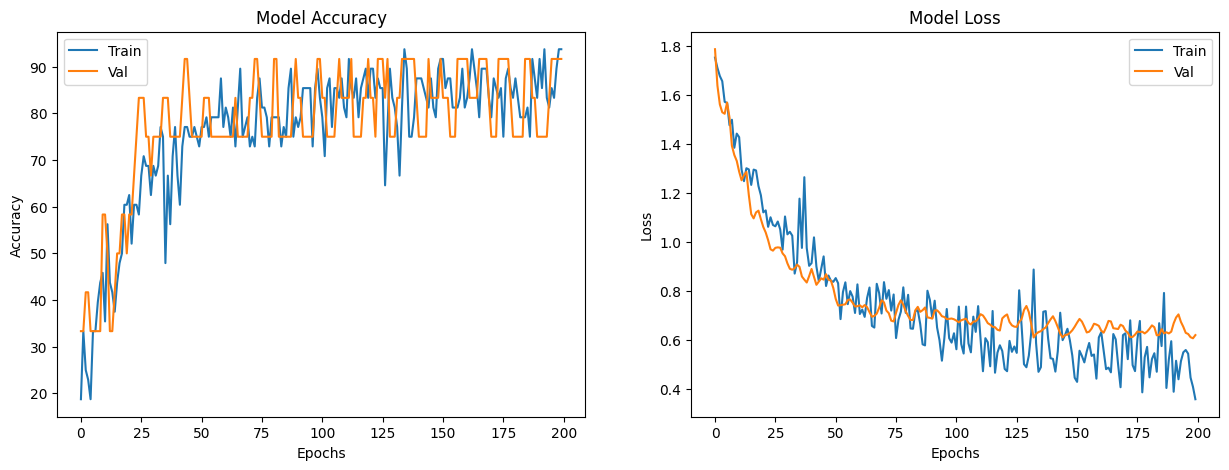

In [204]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and validation accuracy
ax[0].plot(train_accuracies)
ax[0].plot(val_accuracies)
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Val'])

# Plotting training and validation loss
ax[1].plot(train_losses)
ax[1].plot(val_losses)
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Val'])

plt.show()

## D. Evaluating Your Trained Model

### Load Trained Model and Evaluate

In [205]:
# Load the trained weights
model.load_state_dict(torch.load('model_classification.pth'))

# Set the model to evaluation mode

model.eval()

test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in val_loader:

        images = images.cuda()

        labels = labels.cuda()
        labels = labels.long()

        outputs = model(images)

        predicted = outputs.argmax(-1)
        print(predicted)
        print(labels)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

print(f'Test accuracy is {100. * test_correct / test_total}%')

tensor([0, 0, 0, 0, 1, 1, 2, 3, 3, 3, 4, 4], device='cuda:0')
tensor([0, 0, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4], device='cuda:0')
Test accuracy is 91.66666666666667%
